In [1]:
import sys
import os
from pathlib import Path

sys.path.append(sys.path[0] + '/src')

In [2]:
import utils
import pandas as pd
from prediction import analyze_data, plot_count, count_data, plot_multi_count

In [3]:
device = utils.getting_device()

train_df =pd.read_csv('data/train_24892.csv')
test_df = pd.read_csv('data/test_13786.csv')
print(train_df.shape, test_df.shape)

device: cuda
(24892, 4) (13786, 4)


## Base: BERT, GPT, CodeBERT, RoBERTa

In [5]:
model = 'bert'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'
bert_dic_lang, bert_dic_task = analyze_data(model, train_df, test_df, device, train_path = train_file, test_path = test_file, mode = 'two_label')

Time elapsed: 0.85 seconds, Data predicted: 1
Time elapsed: 194.32 seconds, Data predicted: 5001
Time elapsed: 193.11 seconds, Data predicted: 10001
Accuracy of Programming Language prediction: 49.97%
Accuracy of Programming Task prediction: 20.03%


In [6]:
model = 'gpt'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'
gpt_dic_lang, gpt_dic_task = analyze_data(model, train_df, test_df, device, train_path = train_file, test_path = test_file, mode = 'two_label')

Time elapsed: 0.40 seconds, Data predicted: 1
Time elapsed: 184.87 seconds, Data predicted: 5001
Time elapsed: 190.76 seconds, Data predicted: 10001
Accuracy of Programming Language prediction: 34.38%
Accuracy of Programming Task prediction: 7.41%


In [7]:
model = 'codegpt'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'
codegpt_dic_lang, codegpt_dic_task = analyze_data(model, train_df, test_df, device, train_path = train_file, test_path = test_file, mode = 'two_label')

Time elapsed: 0.38 seconds, Data predicted: 1
Time elapsed: 184.25 seconds, Data predicted: 5001
Time elapsed: 186.29 seconds, Data predicted: 10001
Accuracy of Programming Language prediction: 57.26%
Accuracy of Programming Task prediction: 19.97%


In [8]:
model = 'codebert'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'
codebert_dic_lang, codebert_dic_task = analyze_data(model, train_df, test_df, device, train_path = train_file, test_path = test_file, mode = 'two_label')

Time elapsed: 0.42 seconds, Data predicted: 1
Time elapsed: 186.13 seconds, Data predicted: 5001
Time elapsed: 183.54 seconds, Data predicted: 10001
Accuracy of Programming Language prediction: 46.79%
Accuracy of Programming Task prediction: 11.63%


In [9]:
model = 'roberta'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'
roberta_dic_lang, roberta_dic_task = analyze_data(model, train_df, test_df, device, train_path = train_file, test_path = test_file, mode = 'two_label')

Time elapsed: 0.32 seconds, Data predicted: 1
Time elapsed: 190.92 seconds, Data predicted: 5001
Time elapsed: 193.33 seconds, Data predicted: 10001
Accuracy of Programming Language prediction: 46.63%
Accuracy of Programming Task prediction: 14.65%


In [10]:
import prediction
import importlib 
importlib.reload(prediction)

import utils
import pandas as pd
from prediction import analyze_data, plot_count, count_data, plot_multi_count

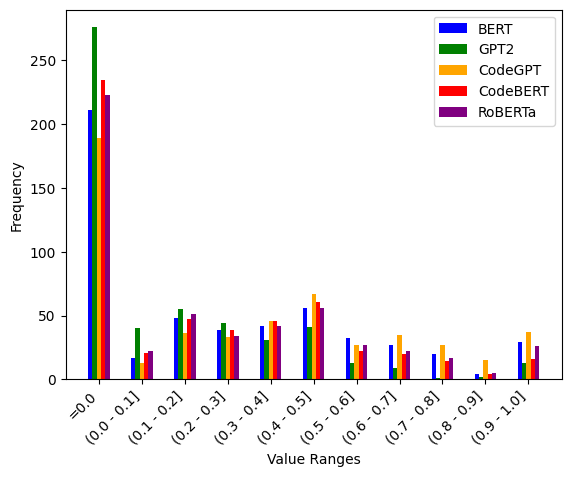

In [11]:
dataset_lang = [bert_dic_lang, gpt_dic_lang, codegpt_dic_lang, codebert_dic_lang, roberta_dic_lang]
data_labels = ['BERT', 'GPT2' , 'CodeGPT' , 'CodeBERT' , 'RoBERTa']

counts = [count_data(data) for data in dataset_lang]
plot_multi_count(counts, data_labels, 'lang')

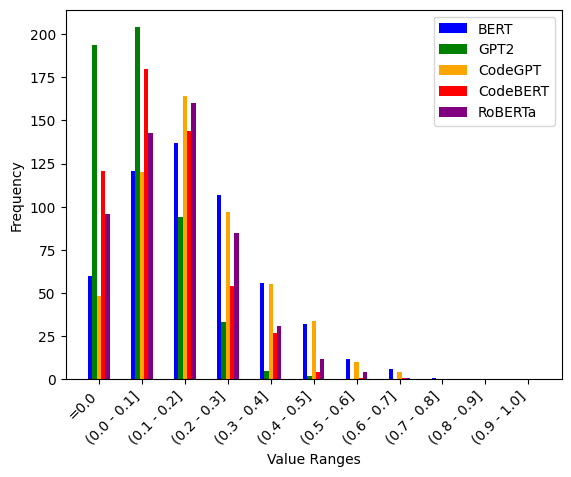

In [12]:
dataset_task = [bert_dic_task, gpt_dic_task, codegpt_dic_task, codebert_dic_task, roberta_dic_task]

counts = [count_data(data) for data in dataset_task]
plot_multi_count(counts, data_labels, 'task')

## Saving/Loading data from the pickle files

In [13]:
import pickle
for i in range(len(data_labels)):
    with open('out/lang_'+data_labels[i]+'.pkl', 'wb') as fp:
        pickle.dump(dataset_lang[i], fp)
    with open('out/task_'+data_labels[i]+'.pkl', 'wb') as fp:
        pickle.dump(dataset_task[i], fp)

In [14]:
import pickle

bert_dic_lang, gpt_dic_lang, codegpt_dic_lang, codebert_dic_lang, roberta_dic_lang = {}, {}, {}, {}, {}
bert_dic_task, gpt_dic_task, codegpt_dic_task, codebert_dic_task, roberta_dic_task = {}, {}, {}, {}, {}
dataset_lang = [bert_dic_lang, gpt_dic_lang, codegpt_dic_lang, codebert_dic_lang, roberta_dic_lang]
dataset_task = [bert_dic_task, gpt_dic_task, codegpt_dic_task, codebert_dic_task, roberta_dic_task]
data_labels = ['BERT', 'GPT2' , 'CodeGPT' , 'CodeBERT' , 'RoBERTa']
for i in range(len(data_labels)):
    with open('out/lang_'+data_labels[i]+'.pkl', 'rb') as handle:
        dataset_lang[i] = pickle.load(handle)
    with open('out/task_'+data_labels[i]+'.pkl', 'rb') as handle:
        dataset_task[i] = pickle.load(handle)

## TWO-SAMPLE T-TEST

In [24]:
import seaborn as sns
from scipy import stats
import numpy as np

data_labels = ['BERT', 'GPT2' , 'CodeGPT' , 'CodeBERT' , 'RoBERTa']

for i in range(len(data_labels)):
    model = data_labels[i]
    # Filter the dataset for the two species we want to compare:
    language_acc = np.array(list(dataset_lang[i].values()))
    task_acc = np.array(list(dataset_task[i].values()))
    
    ## Perform the t-test:
    t_stat, p_value = stats.ttest_ind(language_acc, task_acc)
    print(model, 't_stat', t_stat, 'p_value', p_value)
    
    # Interpret the results:
    alpha = 0.05
    if p_value < alpha:
        print(": Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT")
    else:
        print(": Fail to reject the null hypothesis; there is no significant difference between the accuracy distribution of PL and PT")

BERT t_stat 5.8051974273846545 p_value 8.498430593906946e-09
: Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT
GPT2 t_stat 8.345778797928268 p_value 2.196980488180567e-16
: Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT
CodeGPT t_stat 9.284854550587255 p_value 8.950741725264139e-20
: Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT
CodeBERT t_stat 9.315616428126381 p_value 6.850605853949738e-20
: Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT
RoBERTa t_stat 8.36394904227269 p_value 1.9016338541967634e-16
: Reject the null hypothesis; there is a significant difference between the accuracy distribution of PL and PT


## Further Train RoBERTa

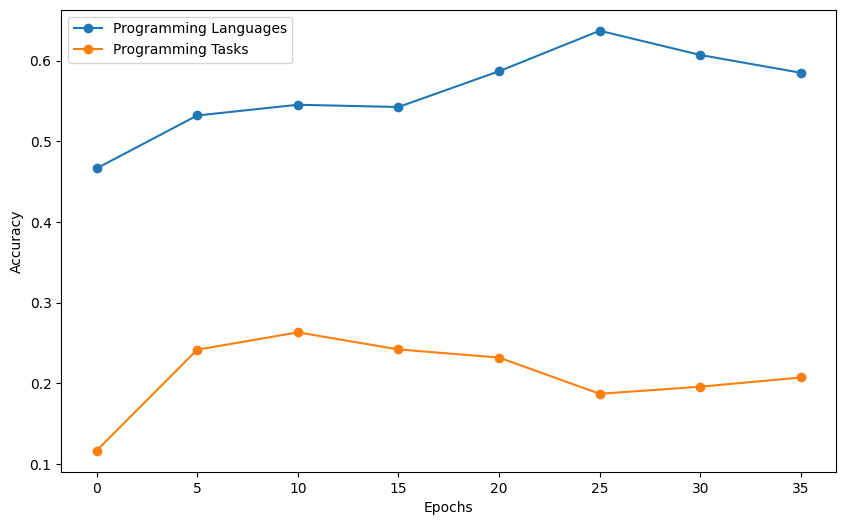

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

acc_lang = [0.4663, 0.5320, 0.5453, 0.5425, 0.5869, 0.6371, 0.6070, 0.5849]
acc_task = [0.1163, 0.2415, 0.2631, 0.2419, 0.2318, 0.1869, 0.1957, 0.2071]
epoch = [i for i in range(0,40,5)]
plt.plot(epoch, acc_lang, marker='o', label='Programming Languages')
plt.plot(epoch, acc_task, marker='o', label='Programming Tasks')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epoch)
plt.legend()
plt.savefig('image/acc_over_epoch.png')

## CodeBERT Six Programming Languages

In [42]:
from prediction import predict_two, caculate_acc, part_data_analysis

languages = ['Go','Java','JavaScript','PHP','Python','Ruby']
model = 'bert'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'

part_data_analysis(languages, train_df, test_df, train_file, test_file)


Time elapsed: 0.06 seconds, Data predicted: 0
Accuracy of Programming Language prediction: 84.81%
Accuracy of Programming Task prediction: 19.02%


## CodeGPT six Programming Languages

In [43]:
languages = ['Go','Java','C++','Kotlin','Python','Julia']
model = 'gpt'
train_file = 'out/'+model+'_24892.pt'
test_file = 'out/'+model+'_13786.pt'

part_data_analysis(languages, train_df, test_df, train_file, test_file)


Time elapsed: 0.07 seconds, Data predicted: 0
Accuracy of Programming Language prediction: 77.93%
Accuracy of Programming Task prediction: 8.34%


## Training

In [ ]:
model = 'epoch4_roberta'

analyze_data(model, train_df, test_df, device, mode = 'emb')

In [ ]:
model = 'epoch1_codebert'

analyze_data(model, train_df, test_df, device, mode = 'emb')

In [ ]:
model = 'epoch2_codebert'

analyze_data(model, train_df, test_df, device, mode = 'emb')

In [ ]:
model = 'epoch3_codebert'

analyze_data(model, train_df, test_df, device, mode = 'emb')

In [ ]:
model = 'epoch4_codebert'

analyze_data(model, train_df, test_df, device, mode = 'emb')

In [ ]:
model = 'epoch5_codebert'

analyze_data(model, train_df, test_df, device, mode = 'emb')